# Intro to filtering and time-series processing

[scipy ref page](https://docs.scipy.org/doc/scipy/reference/signal.html)

## Topics - 
* basic demo of lp, hp, bp filters implenmented in time and freq domains. 
* wavelet transforms
* peak finding using wv transforms
[link here](https://plot.ly/python/fft-filters/)

[link pdf](file:///C:/Users/jserences/Downloads/Lecture_06_FIR_IIR_filters.pdf)

[link pdf](file:///C:/Users/jserences/Downloads/Lecture_07_Statistical_filtering.pdf)


## linear filters
* 
* Multiply FFT of timeseries by a transfer function, which is the FFT of time domain implementation of the filter
* A low-pass filter in the freq domain is a square wave that has a sharp cutoff (so passes everything below the cutoff and passing nothing above the cut-off)
    * However, a sharp edge filter contains energy at all frequencies, so has no true fall off.
    * Windowing functions reduce the ripple (rapid oscillations near the edge of the band), but extend the roll-off.
    * Butterworth is a popular alternative...

## Imports

In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import signal

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Low pass filter
* Ideal low pass filter will only let through frequencies you want to keep and will truncate all high undesired high frequencies
* This will look like a step function in the frequency domain
* Take the followings steps to illustrate
    * Generate a complex signal that we can use for simulations
    * Make a step function filter in the frequency domain and see what happens...

In [227]:
# define a set of frequencies for our similated signal. 
# lets not add any IID noise yet so that the results turn out the same each time
Lf = 1  # lowest frequency
Hf = 16 # highest frequency

#generate list
frequs = np.linspace(Lf, Hf-1, Hf-Lf)
print(frequs)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.]


In [228]:
# make our simulated signal
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig = sig + np.sin(2*np.pi*frequs[f]*t)

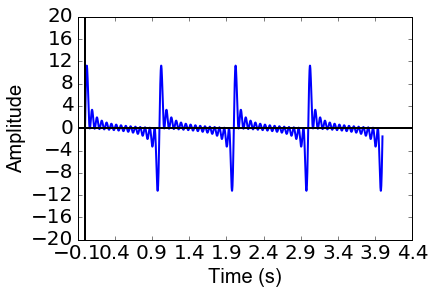

In [230]:
# Plot
plt.plot(t, sig, 'b-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,20,11), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Now FFT and lets have a look at the frequency spectrum 

In [247]:
# rfft = fft for real valued inputs
sp = np.fft.rfft(sig)      
# remember our coordinate system that we talked about earlier...this is the distance from the origin
amp = np.abs(sp)  

# normalize by the number of data points, 
# x2 cause we're ditching the negative frequencies when we deal with real numbers
amp = (amp  / len(sig) ) * 2   

# figure out the frequency resolution of the data 
freq = np.fft.rfftfreq(sig.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!

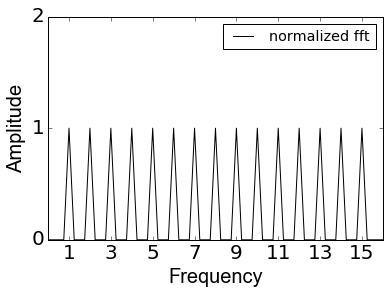

In [248]:
# plot the fft
plt.plot(freq, amp, 'k')            # plot amplitude 

# put a legend on it...
plt.legend(['normalized fft'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf])

# show it
plt.show()

## Now design the perfect low pass filter - one that only passes frequencies below the cutoff and truncates everything else!
* Note that this will look like a box-car function in the frequency domain
* If you multiply this filter with the FFT of the original data, and then iFFT, you should only have low frequencies left!
* This kind of filter with a hard cutoff is often referred to as a brick-wall filter

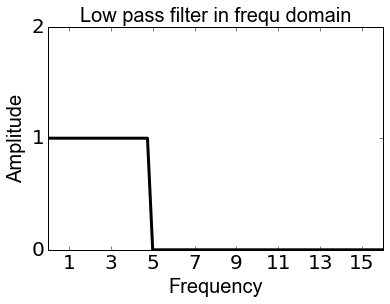

In [320]:
# lets pass everything blow 7Hz and cut off everything else
lowpass_cut = 5

# find the freq in our FFT range that is closest to our desired cutoff point
cutoff_pnt = np.argmin(np.abs(freq-lowpass_cut))

# make the filter
lp_filt = np.zeros(len(freq))
lp_filt[0:cutoff_pnt] = 1

plt.plot(freq, lp_filt, c='k', linewidth=3)
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)
# set the axis limits
plt.xlim([0, Hf])
plt.title('Low pass filter in frequ domain', **fig_font)
plt.show()

## Apply the filtering by multiplying it with the data 
* To filter data, you can multiply the fft of your signal with the frequency domain representation of the filter...


In [321]:
# do the mutliplication in the frequ domain
# NEED THE COMPLEX VALUED SIGNAL, not just the amplitude

# filter the data (multiply, iFFT)
# do it in steps here to make it clear
multiply_in_frequ_domain = sp*lp_filt
# take the ifft
filtered_sig = np.fft.irfft(multiply_in_frequ_domain)

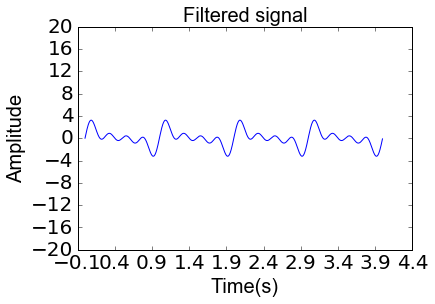

In [322]:
# plot the filtered data...all the high frequency stuff > 7Hz should be gone!
plt.plot(t, filtered_sig)
plt.xlabel('Time(s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,20,11), color='k', size=20)
plt.title('Filtered signal', **fig_font)
plt.show()

## What does that filter look like in the time domain?
* Inverse FFT the low-pass filter

<div class="alert alert-info">
Notice that that the time-domain representation goes on forever in either direction...this is a problem for implementing with finite length data sets! We'll see how to address this below. 
</div>

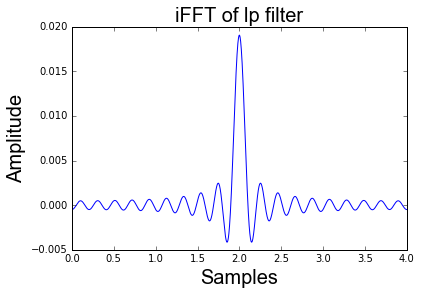

In [323]:
# iFFT
inv_filter = np.fft.irfft(lp_filt)

# symetric over the span, so center to better visualize
inv_filter = np.roll(inv_filter, int(len(inv_filter)/2))
plt.plot(t, inv_filter)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('iFFT of lp filter', **fig_font)
plt.show()

## Now take a look at how to design this kind of filter in a more principled manner
* the iFFT of an ideal lp filter is a sinc function
* can build the function in the time domain, then fft the filter and the signal, the multipl, then iFFT to get our filtered signal!

In [304]:
fc = 0.1
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
# Blackman window
# window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
# # Hanning window
# sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

## Plot the sinc function

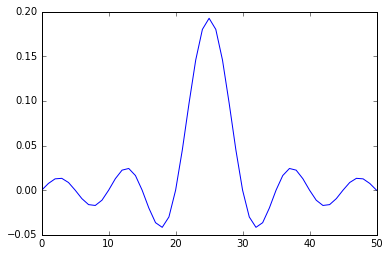

In [305]:
plt.plot(sinc_func)

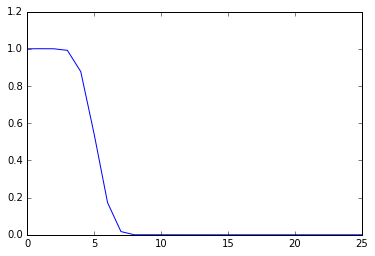

In [242]:
plt.plot(np.abs(np.fft.rfft(sinc_func)))